### Ethereum Wallet transactions analysis!
In this project we will:
- get data from Etherscan API
- make required data transactions
- visualize data using Tableau
- analyze patterns
- calculate the economic efficiency of financial strategy of ETH address.

#### **Task**

- Based on the history of transactions of ETH address: *0x99FD1378ca799ED6772Fe7bCDC9B30B389518962*, from Etherscan: *https://etherscan.io/address/0x99fd1378ca799ed6772fe7bcdc9b30b389518962*  
- Analyze financial strategy of ETH address
- We will describe data collection process
- Transform data to help in analysis
- Then we will make analysis using visualization in Tableau

##### Data
- There are 2 ways how we can get data from Etherscan:
    - simply download csv file to take a look at the data from there, Etherscan allows to download 5000 transactions as csv  
there are 7911 transactions in total for that account, therefore we will download 2 files:
1.  very beginning - 2021-05-31
2. 2021-06-01 - till today

    - Or use Etherscan API (will be shown later)

In [7]:
import pandas as pd
import numpy as np

from datetime import datetime

In [2]:
df_1 = pd.read_csv('./data/user_data_1.csv')
df_2 = pd.read_csv('./data/user_data_2.csv')

In [3]:
number_rows_1 = len(df_1)
print(f'number of rows in first part of data: {number_rows_1}')

number_rows_2 = len(df_2)
print(f'number of rows in second part of data: {number_rows_2}')

df_csv = pd.concat([df_1, df_2]).reset_index(drop=True)
total_number_rows = len(df_csv)
print(f'total number of rows {total_number_rows}')

number of rows in first part of data: 4125
number of rows in second part of data: 3788
total number of rows 7913


Get data from API:

In [12]:
import requests
import certifi

import os
from dotenv import load_dotenv
load_dotenv()
access_token = os.getenv('MY_ACCESS_TOKEN')

In [14]:
#Get a list of 'Normal' Transactions By Address
address = '0x99FD1378ca799ED6772Fe7bCDC9B30B389518962'
number_of_transactions = 10000

url = "https://api.etherscan.io/api" + \
      "?module=account" + \
      "&action=txlist" + \
      "&address=" + address + \
      "&startblock=0" + \
      "&endblock=9999999999999999" + \
      "&page=1" + \
      "&offset=" + str(number_of_transactions) + \
      "&sort=asc" + \
      "&apikey=" + access_token

response = requests.get(url, verify=certifi.where())
address_content = response.json()

In [15]:
number_of_rows_from_API = len(address_content['result'])
print(f'number of rows from API request: {number_of_rows_from_API}')

number of rows from API request: 8239


We get the same number of rows, therefore we can use either data set, for now we will use dataset from CSV file downloaded from Etherscan, since it has adopted data (datetime columns and methods) and we do not have to merge it (methods) from other requests, but we obviously Can :)   
 
on the current stage we fixed amount of data

In [16]:
df_csv.columns

Index(['Txhash', 'Blockno', 'UnixTimestamp', 'DateTime', 'From', 'To',
       'ContractAddress', 'Value_IN(ETH)', 'Value_OUT(ETH)',
       'CurrentValue @ $1084.99/Eth', 'TxnFee(ETH)', 'TxnFee(USD)',
       'Historical $Price/Eth', 'Status', 'ErrCode', 'Method', 'empty',
       'CurrentValue @ $1103.42/Eth'],
      dtype='object')

#### Columns description:
- Txhash - Transaction Hash: A unique identifier that can be used to locate a specific transaction
- Blockno - Block: The block number that the transaction was included in.
- UnixTimestamp - Timestamp: The time that the block was mined in UTC.
- DateTime - date and time of transaction  
- From - From: The account that originally sent the transaction.   
- To - To: The account that the transaction is addressed to.  
- ContractAddress - ?  
- Value_IN(ETH) - amount of ETH that transfered to the account of interest ("user_1")  
- Value_OUT(ETH) - amount of ETH that tranfered from the account of interest ("user_1")  
- CurrentValue @ $1098.81/Eth - Value of transaction in USD according to the current price  
- TxnFee(ETH) - Transaction Fee: The amount of Ether paid to the miner for processing the transaction, which is calculated by multiplying the amount of gas used by the gas price.  
- TxnFee(USD) - transaction fee in USD  
- Historical $Price/Eth - Price of USD/ETH price at the moment of transaction  
- Status - Status: The current state of a transaction (Success, Failed, or Pending).  
- ErrCode - code of error
- Method - type of transaction

In [17]:
# fix: columns Change error_code and status:

# new column "error_code":
df_csv['error_code'] = df_csv['Status']
# new column 'status':
df_csv['status'] = df_csv['ErrCode']

# drop old columns:
df_csv = df_csv.drop(columns=['ErrCode', 'Status', 'empty'])

In [18]:
user_1 = '0x99fd1378ca799ed6772fe7bcdc9b30b389518962'

In [19]:
df_csv.columns

Index(['Txhash', 'Blockno', 'UnixTimestamp', 'DateTime', 'From', 'To',
       'ContractAddress', 'Value_IN(ETH)', 'Value_OUT(ETH)',
       'CurrentValue @ $1084.99/Eth', 'TxnFee(ETH)', 'TxnFee(USD)',
       'Historical $Price/Eth', 'Method', 'CurrentValue @ $1103.42/Eth',
       'error_code', 'status'],
      dtype='object')

Some values in column Method does not look like Types of transactions,  
they look more like error code,  
- so we change values in such rows to 'error' in Method column
- and store values of this errors in error_code column  
- we will lost Error(0) code in error_code column (we could keep it, but it will not affect the analysis, since it is 100% the same as "Reverted" status)

In [20]:
# function to fill error_code column:
def check_error_code(value):
    result = np.nan
    if value[0:2] == '0x': # return error codes
        result = value
    return result

# function to fill Method column
def check_method(value):
    result = np.nan
    if value[0:2] != '0x': # return only methods
        result = value
    return result


# apply to error_code column:
df_csv['error_code'] = df_csv['Method'].apply(lambda x: check_error_code(x))
# apply to method column:
df_csv['Method'] = df_csv['Method'].apply(lambda x: check_method(x))

In [21]:
total_n_rows = len(df_csv)
print(f'total number of rows in dataset: {len(df_csv)}')

rows_n_user_1_sender = len(df_csv[(df_csv['From'] == user_1) & (df_csv['To'] != user_1)] ) # only sender not receiver
share_sender = round(rows_n_user_1_sender / total_n_rows * 100, 2)
print(f'rows where user_1 is sender: {rows_n_user_1_sender}, which is {share_sender}%')

rows_n_user_1_receiver = len(df_csv[(df_csv['To'] == user_1) & (df_csv['From'] != user_1)]) # only receiver not sender
share_receiver = round(rows_n_user_1_receiver / total_n_rows * 100, 2)
print(f'rows where user_1 receives: {rows_n_user_1_receiver}, which is {share_receiver}%')

rows_n_receiver_and_sender = len(df_csv[(df_csv['From'] == user_1) & (df_csv['To'] == user_1)])
share_send_receive_sim = round( rows_n_receiver_and_sender / total_n_rows * 100, 2  )
print(f'number of rows where user_1 is receiver and sender simultaneously: {rows_n_receiver_and_sender}, which is {share_send_receive_sim}%')

check_sum = rows_n_user_1_receiver + rows_n_user_1_sender + rows_n_receiver_and_sender
check_sum_percentage = share_sender + share_receiver + share_send_receive_sim
print()
print(f'Check: sum rows and send rows receive: {check_sum}, sum of percentage: {check_sum_percentage} %')

total number of rows in dataset: 7913
rows where user_1 is sender: 7546, which is 95.36%
rows where user_1 receives: 334, which is 4.22%
number of rows where user_1 is receiver and sender simultaneously: 33, which is 0.42%

Check: sum rows and send rows receive: 7913, sum of percentage: 100.0 %


##### Values in USD
Now, let us calculate Actual Values of Transactions in USD, to do that we will convert ETH to USD based on historical Exchage rate

but before, find how many Rate values are Empty:

If there would be any rows with empty Historical data, it could occur in transaction of current date, for that cases, fill such cells with current price

In [22]:
# fill empty price history as current price
current_price = float(df_csv.columns[9][16:23])
df_csv.loc[df_csv['Historical $Price/Eth'].isna(), 'Historical $Price/Eth'] = current_price
print(f'current price: {current_price} usd/eth')

current price: 1084.99 usd/eth


In [23]:
# create calculated fields Actual amount in USD:
df_csv['Value_IN(USD)'] = df_csv['Value_IN(ETH)'] * df_csv['Historical $Price/Eth']
df_csv['Value_OUT(USD)'] = df_csv['Value_OUT(ETH)'] * df_csv['Historical $Price/Eth']

Look at totals: (we consider rows where address is receiver and sender simultaneously twice, in 2 cases it is big values, so we should be aware of that, so we will not consider those rows, since they influence only by Transaction fee on balance)

! It is important to note that here we did not filtered Reverted transactions, since they do not have too much influence on the total picutre, but it is important to remember  
we will filter such transactions in Tableau later

In [24]:
df_send = df_csv[(df_csv['From'] == user_1) & (df_csv['To'] != user_1)]
df_receive = df_csv[(df_csv['To'] == user_1) & (df_csv['From'] != user_1)]

sum_value_in = round(df_receive['Value_IN(ETH)'].sum(), 2)
sum_value_out = round(df_send['Value_OUT(ETH)'].sum(), 2)
margin_total = sum_value_in - sum_value_out

print(f'Total IN = {sum_value_in} ETH, Total OUT = {sum_value_out} ETH, Total Margin = {margin_total} ETH')

Total IN = 167320.61 ETH, Total OUT = 1337997.03 ETH, Total Margin = -1170676.42 ETH


by looking at the amount of ETH, it may seem like Outflow is greater then Inflow  
let's look at the amount in USD:

In [23]:
sum_value_in = round(df_receive['Value_IN(USD)'].sum(), 2)
sum_value_out = round(df_send['Value_OUT(USD)'].sum(), 2)
margin_total = sum_value_in - sum_value_out

print(f'Total IN = {sum_value_in} USD, Total OUT = {sum_value_out} USD, Total Margin = {margin_total} USD')

Total IN = 469072264.94 USD, Total OUT = 3091814686.31 USD, Total Margin = -2622742421.37 USD


Margin is also negative here  
For me it looks strange, since if we had all transactions, we would expect only 0 balance and not negative (in ETH), and we could expect negative balance in USD due to change Exchange rate, also, we did not consider transaction fees yet and they would have big effect on balance since transaction fees are high in Ethereum network

therefore, using Etherscan API, let's get Current Balance of the Address to check our results:

In [24]:
#Get Ether Balance for a Single Address
addess = '0x99FD1378ca799ED6772Fe7bCDC9B30B389518962'

url = "https://api.etherscan.io/api" + \
      "?module=account" + \
      "&action=balance" + \
      "&address=" + addess + \
      "&tag=latest" + \
      "&apikey=" + access_token

response = requests.get(url, verify=certifi.where())
latest_balance_data = response.json()

In [25]:
# 18 - is number of decimals (because ehtereum network does not work with decimals, all values are in Wei)
latest_balance = float(latest_balance_data['result']) / 10**18 
print(f'latest balance of user_1 address = {round(latest_balance, 3)} ETH')

latest balance of user_1 address = 538.914 ETH


Therefore, we can see that the Actual Ether balance is positive in the Address, therefore there are some data that we miss in the consideration

Lets take a look also on the earliest balance:

In [26]:
#Get Ether Balance for a Single Address
addess = '0x99FD1378ca799ED6772Fe7bCDC9B30B389518962'

url = "https://api.etherscan.io/api" + \
      "?module=account" + \
      "&action=balance" + \
      "&address=" + addess + \
      "&tag=earliest" + \
      "&apikey=" + access_token

response = requests.get(url, verify=certifi.where())
earliest_balance_data = response.json()

In [27]:
earliest_balance = float(earliest_balance_data['result']) / 10**18 
print(f'earliest balance of user_1 address = {round(earliest_balance, 3)} ETH')

earliest balance of user_1 address = 538.914 ETH


Greate! we can see that the very first balance was 0, which is logical

Our task is to understand the financial stategy of the Address

In [28]:
# save data for analysis
df_csv.to_csv('./data/data_csv.csv', sep=',')

In [29]:
df_csv.columns

Index(['Txhash', 'Blockno', 'UnixTimestamp', 'DateTime', 'From', 'To',
       'ContractAddress', 'Value_IN(ETH)', 'Value_OUT(ETH)',
       'CurrentValue @ $1084.99/Eth', 'TxnFee(ETH)', 'TxnFee(USD)',
       'Historical $Price/Eth', 'Method', 'CurrentValue @ $1103.42/Eth',
       'error_code', 'status', 'Value_IN(USD)', 'Value_OUT(USD)'],
      dtype='object')

### General statistics

Lets find out with how many different account User_1 have transactions:

In [30]:
from_addresses = list(df_csv['From'].unique())
from_addresses_len = len(from_addresses)

to_addresses = list(df_csv['To'].unique())
to_addresses_len = len(to_addresses)

all_addresses = from_addresses.copy()
# check is address is not in list, add to have all contracts:
for address in to_addresses:
    if address not in all_addresses:
        all_addresses.append(address)
    
all_addresses_len = len(all_addresses)

print(f'number of unique addresses which send transactions to user: {from_addresses_len}')
print(f'number of unique transactions to which user send transactions: {to_addresses_len}')

print()
print(f'number of all unique addresses: {all_addresses_len}')
print(f'number of accounts that were in both senders and receivers: {from_addresses_len+to_addresses_len-all_addresses_len}')

number of unique addresses which send transactions to user: 54
number of unique transactions to which user send transactions: 396

number of all unique addresses: 444
number of accounts that were in both senders and receivers: 6


In [31]:
df_groupping = df_csv.groupby(['From'], as_index=False).agg({
    'Value_IN(ETH)': sum,
    'Txhash': 'count'
}).sort_values(by='Value_IN(ETH)', ascending=False).head(10)
df_groupping.columns = ['address sender to user_1', 'sum_value(ETH)', 'number of transactions']
df_groupping

,address sender to user_1,sum_value(ETH),number of transactions
44,0xc098b2a3aa256d2140208c3de6543aaef5cd3a94,88839.387199,103
11,0x2a67035357c3045438f3a92e46870a9e48e5aab7,39566.761902,90
23,0x58f56615180a8eea4c462235d9e215f72484b4a3,16010.861660,7
38,0x937cdc9e86ba06aa5aaea221017a1d9fc7f59efd,10269.950000,41
42,0xab07bf2548bc22b9211469a11d09f83d26611d72,4544.608387,3
46,0xc333e80ef2dec2805f239e3f1e810612d294f771,1353.591500,8
18,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,1149.774050,1
17,0x3bf57ca56baba3bc357e055bcce48565d95a6906,1063.094002,1
33,0x7dac3ea4b99b15ec53cfa0f37510dd828b27895d,849.998577,1
27,0x679c686b4b6934007aeb54b3dfc4a59d52b4ee39,699.997995,1


these are to 10 accounts that sent ETH to User_1

In [32]:
df_groupping =  df_csv.groupby(['To'], as_index=False).agg({
    'Value_OUT(ETH)': sum,
    'Txhash': 'count'
}).sort_values(by='Value_OUT(ETH)', ascending=False).head(10)
df_groupping.columns = ['address receiver from user_1', 'sum_value(ETH)', 'number of transactions']
df_groupping

,address receiver from user_1,sum_value(ETH),number of transactions
383,0xf859a1ad94bcf445a406b892ef0d3082f4174088,309054.265255,95
131,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,258423.164458,325
175,0x67b66c99d3eb37fa76aa3ed1ff33e8e39f0b9c7a,238042.027574,70
232,0x92be6adb6a12da0ca607f9d87db2f9978cd6ec3e,153420.015707,76
354,0xdc24316b9ae028f1497c275eb9192a3ea0f67022,141689.241265,28
1,0x0074aa8dacc40ad79b12e5239a6fe6684fc876e9,68550.000000,37
235,0x937cdc9e86ba06aa5aaea221017a1d9fc7f59efd,44427.158799,36
372,0xeea3311250fe4c3268f8e684f7c87a82ff183ec1,20440.618597,8
395,0xff590dc002e305852179af8e3184d2f640c8362e,20000.000000,3
331,0xcc9a0b7c43dc2a5f023bb9b738e45b0ef6b06e04,17904.182312,4


And these are top 10 addresses that User_1 sent ETH to

# Tableau  
[link_to_dashboard](https://public.tableau.com/app/profile/aleksei5255/viz/Transaction_Analytics_Ethrerscan/AddressAnalytics)

Let's look at the dynamics of ETH Flow:

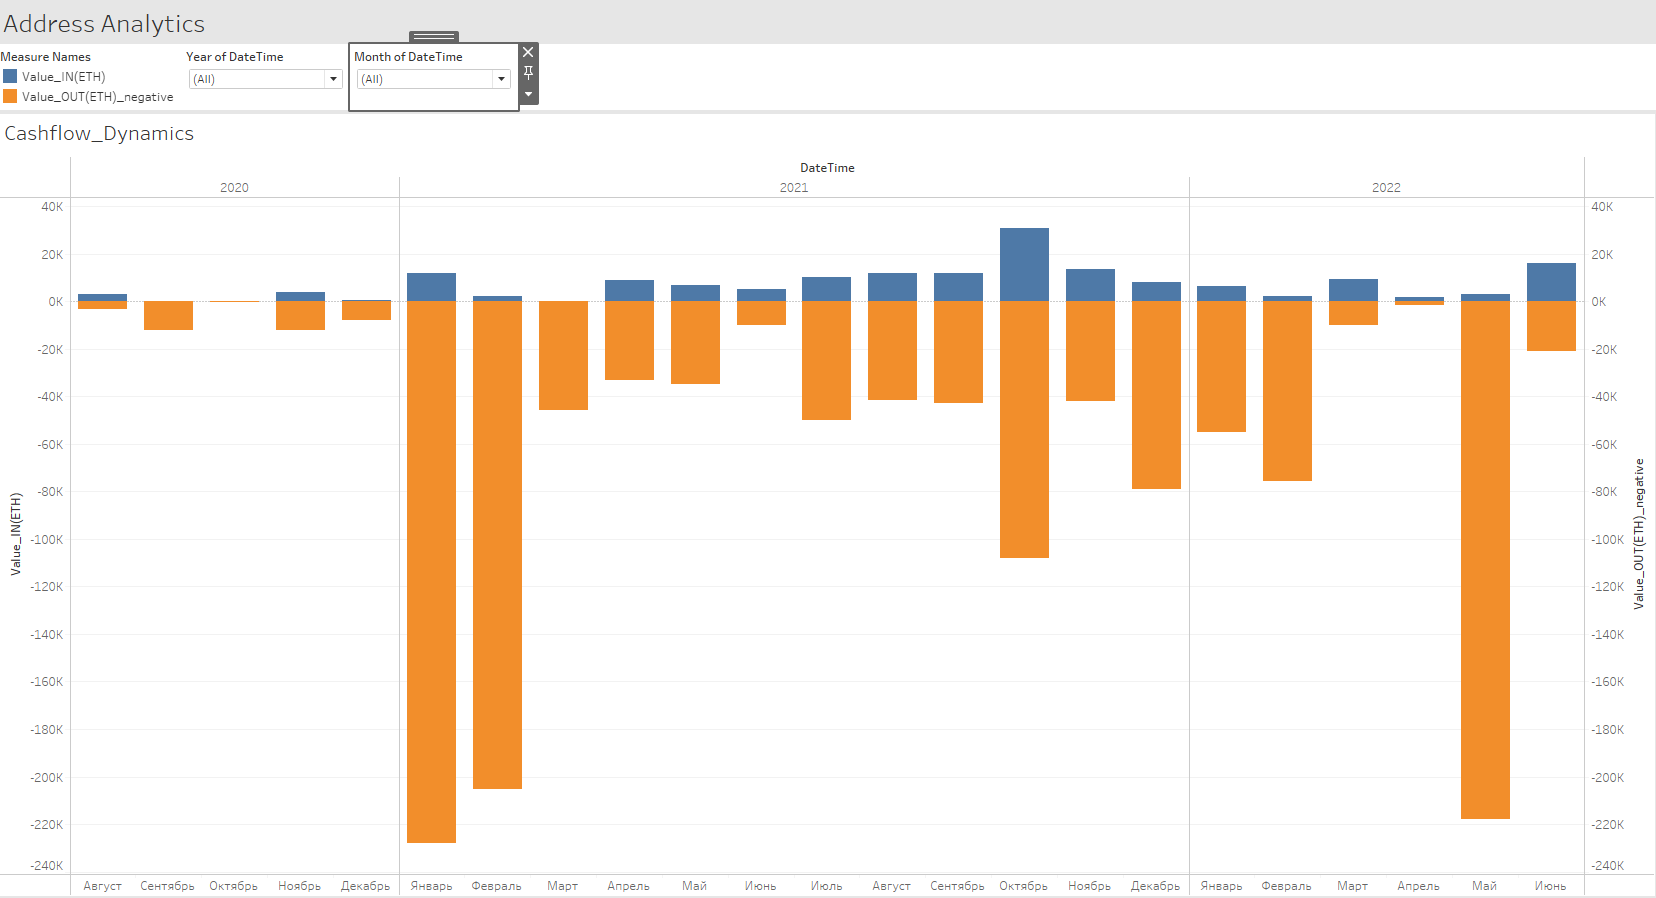

In [2]:
from IPython.display import Image
Image(filename='./pic/ETH_flow.png')

Aggregating by month we can see that the Ouflow cashflow is indeed much higher for the address


Let's now take a look at the Balance history of the Address balance:

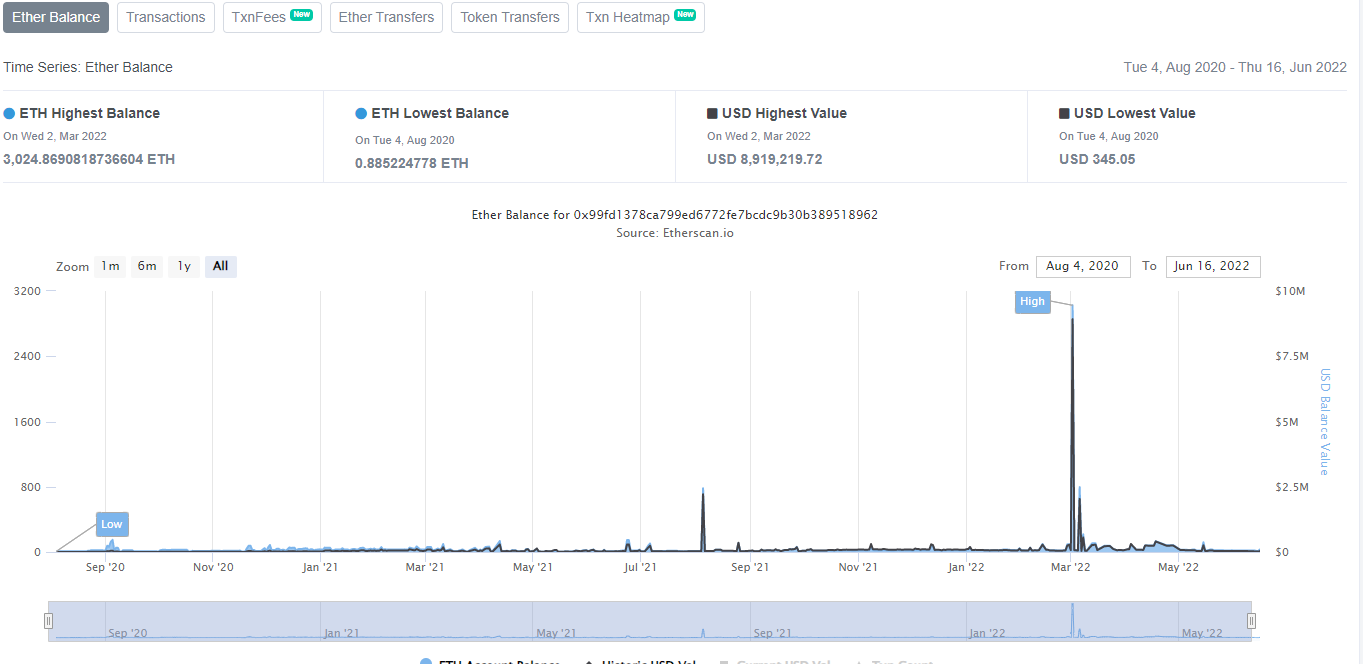

In [5]:
Image(filename='./pic/ehterscan_balance_graph.png')

we can see that the balance is usually small, except some points highs (top at more then 3 000 ETH!), it means that the address user probably invests in some assets and actively trade, so there is no free ETH on the balance, only small (in time) peaks when balance is high, probably due to transferring assets from one place to another or Swap (trade)

# Data Consistency!

To locate the causes of differences in data, let's look at the Tansactions in January of 2021:

By looking at transactions, we see negative outflow, but Etherscan does not show that

Transactions by day:  


In [8]:
df_jan_21 = pd.read_csv('./data/test/jan_2021.csv')

In [38]:
df_jan_nozero = df_jan_21[(df_jan_21['Value_IN(ETH)'] != 0) | (df_jan_21['Value_OUT(ETH)'] != 0)]
df_jan_nozero = df_jan_nozero.reset_index(drop=True)
df_jan_nozero['DateTime'] = pd.to_datetime(df_jan_nozero['DateTime'])
df_jan_nozero['Day'] = df_jan_nozero['DateTime'].dt.day
df_jan_nozero['Month'] = df_jan_nozero['DateTime'].dt.month
df_jan_nozero['Year'] = df_jan_nozero['DateTime'].dt.year

In [39]:
df_check_sum = df_jan_nozero.groupby(['Year', 'Month', 'Day'], as_index=False).agg({
    'Value_IN(ETH)': sum,
    'Value_OUT(ETH)': sum
})
df_check_sum['Diff'] = df_check_sum['Value_IN(ETH)'] - df_check_sum['Value_OUT(ETH)']

In [40]:
df_check_sum.head()

,Year,Month,Day,Value_IN(ETH),Value_OUT(ETH),Diff
0,2021,1,1,157.00000,504.157428,-347.157428
1,2021,1,5,1.00000,1.000000,0.000000
2,2021,1,7,50.00000,33359.455624,-33309.455624
3,2021,1,9,1734.21166,1726.695317,7.516343
4,2021,1,10,0.00000,17053.324666,-17053.324666


Let's consider 2021-01-01: by aggregating only transactions data on Daily basis we see:  
- Value_OUT(ETH) Amount = 504.157
- Value_IN(ETH) Amount = 157.00  


At the same time, if we check transactions on Etherscan in that period, we could see:   

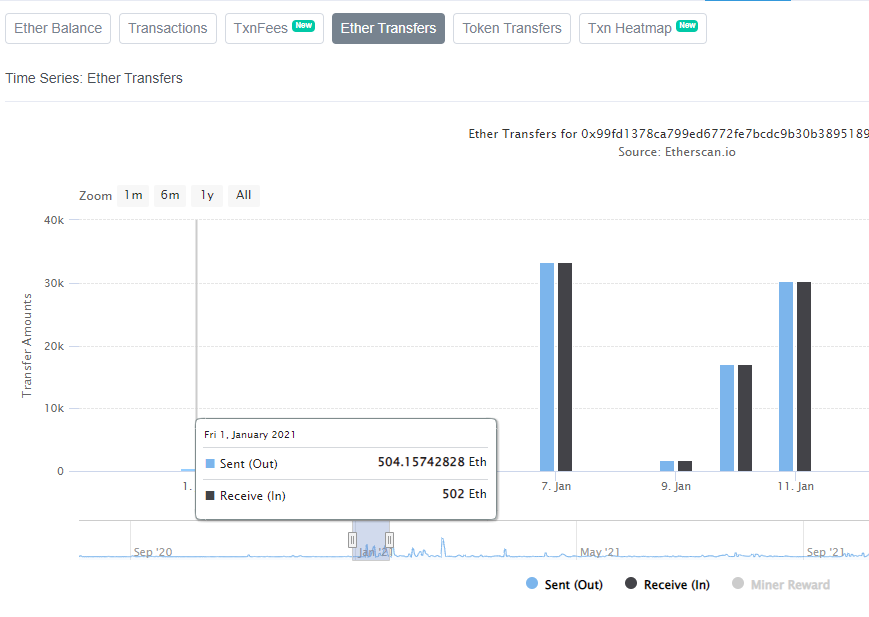

In [9]:
Image(filename='./pic/6_jan_2021_transactions_Etherscan.png')

- Exact match of Amount Sent (OUT) and Different value (bigger) in amount Receive (IN)
    - Logically, this can be due to not completeness of information in our analysis  

let's find that specific transaction and have a closer look on it:  

We want to find 345 ETH

In [41]:
df_jan_nozero_short = df_jan_nozero[df_jan_nozero['Day'] == 1]
df_jan_nozero_short = df_jan_nozero_short[['Txhash', 'DateTime', 'From', 'To', 'Value_IN(ETH)', 'Value_OUT(ETH)']]

In [42]:
df_jan_nozero_short

,Txhash,DateTime,From,To,Value_IN(ETH),Value_OUT(ETH)
0,0xdcc7b59f81fe431c06e346fde6d4cec8e8d591090451...,2021-01-01 20:17:04,0xc098b2a3aa256d2140208c3de6543aaef5cd3a94,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,157.0,0.000000
1,0x60b59e16168d9cfba3cfd0e83e9bb80e1a9ea1d243da...,2021-01-01 20:34:22,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5,0.0,504.157428


In that day, there was 2 transactions made with Address, let's look at both of them:

0xdcc7b59f81fe431c06e346fde6d4cec8e8d591090451 (2021-01-01 20:17:04) - transaction to the Address of interest:  


In [43]:
df_jan_nozero_short['Txhash'][0]

'0xdcc7b59f81fe431c06e346fde6d4cec8e8d591090451d42f758e53989a6915e6'

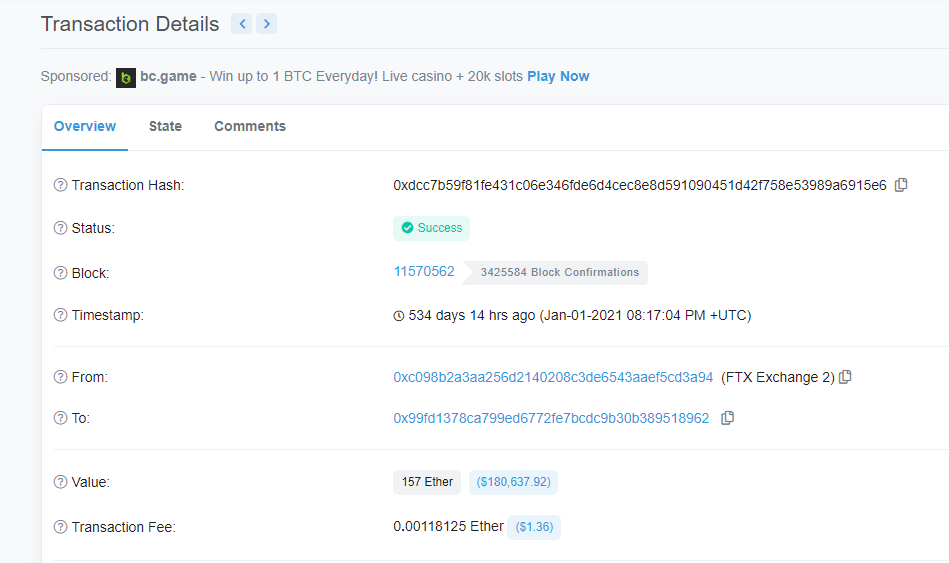

In [10]:
Image(filename='./pic/7_Transaction_2021-01-01_1_ETH-157.png')

Value inside the transaction is exactly the same as we see in our Analysis, let's now check second transaction

In [44]:
df_jan_nozero_short['Txhash'][1]

'0x60b59e16168d9cfba3cfd0e83e9bb80e1a9ea1d243da974a160dfb0e459ffe8e'

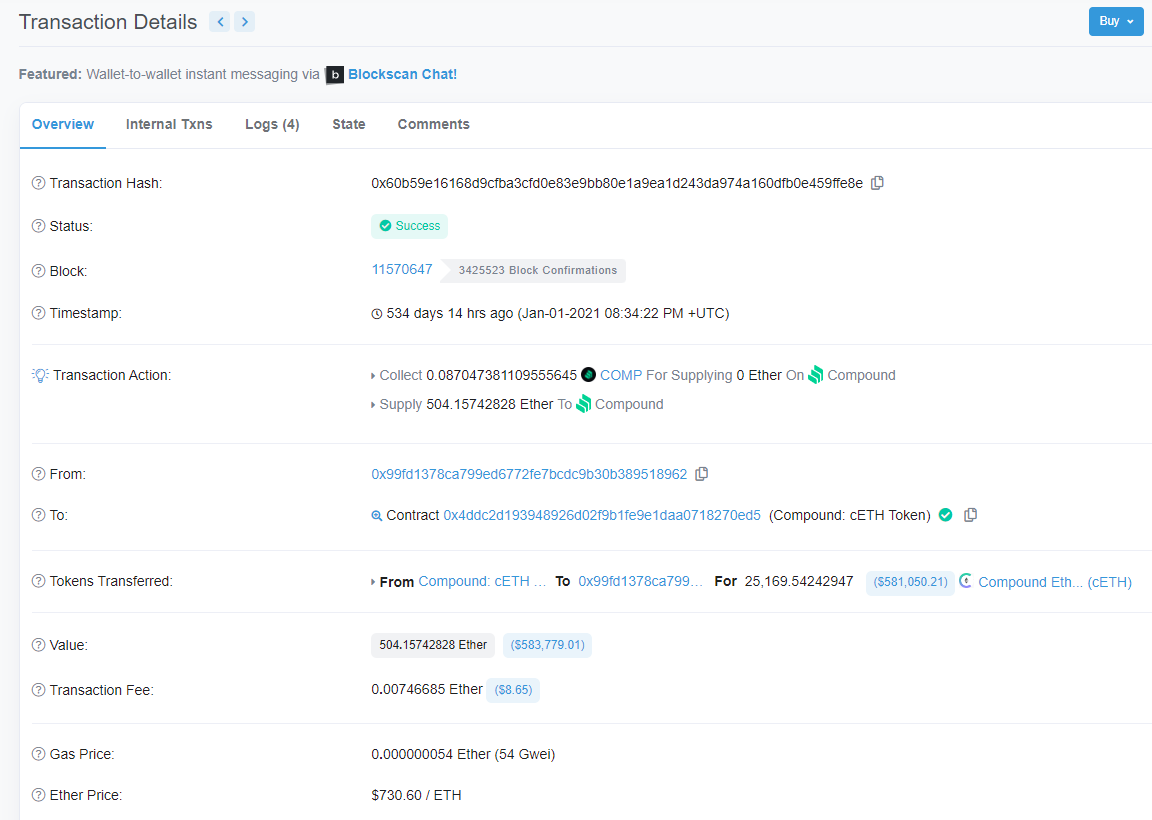

In [11]:
Image(filename='./pic/8_Transaction_2021-01-01_1_ETH-504.png')

We can see the same value as in Analysis, but now, there are Logs presented!  
Since, this transaction was conducted with Smart contract, there could be much more logic in one transaction, then simply transfer of ETH:  
let's look at Logs to get more details:

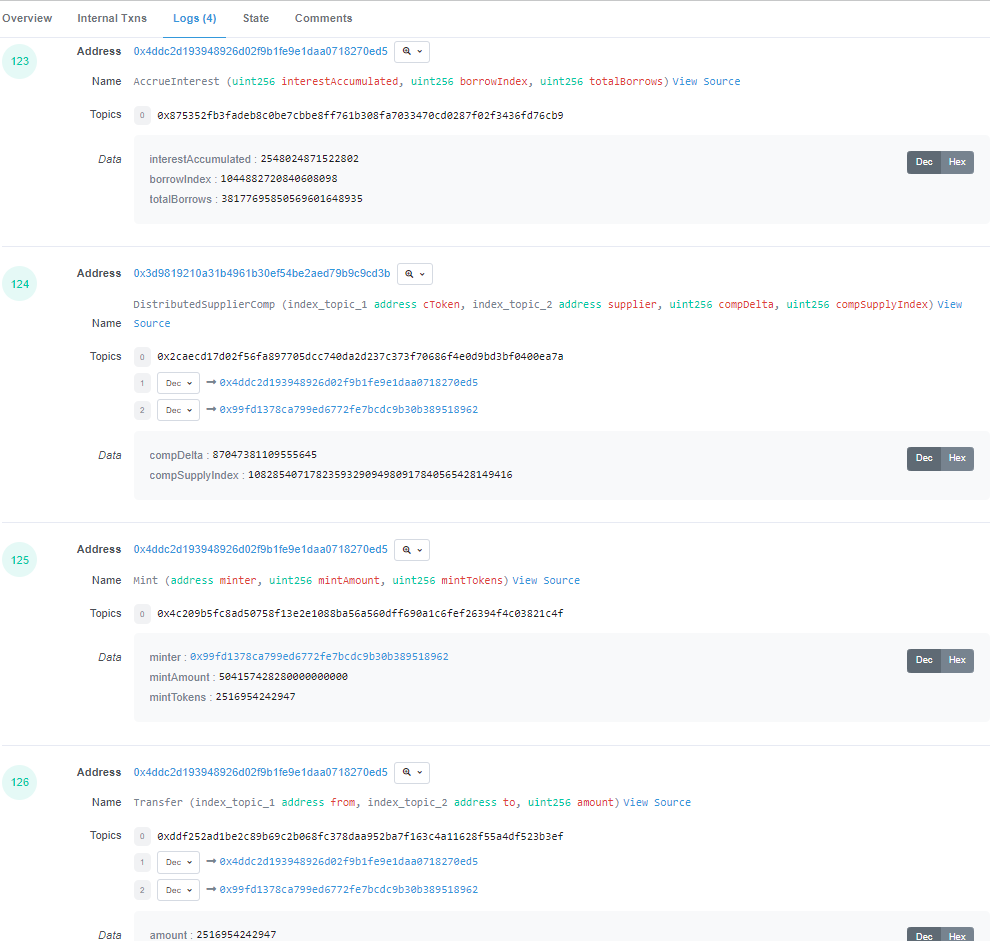

In [12]:
Image(filename='./pic/9_Logs.png')

Indeed, there are more data inside of the transaction logs!

This transaction says, that user put his/her ETH into Compound Interest App (https://compound.finance/) to earn interest on ETH

In [45]:
#1:
interestAccumulated = 2548024871522802
totalBorrows = 38177695850569601648935

interestAccumulated_ETH = interestAccumulated / 10**18
totalBorrows_ETH = totalBorrows / 10**18

print(f'interest accumulated(ETH) = {interestAccumulated_ETH} ETH')
print(f'total Borrows (ETH)= {totalBorrows_ETH} ETH')

interest accumulated(ETH) = 0.002548024871522802 ETH
total Borrows (ETH)= 38177.6958505696 ETH


In [46]:
# 2
compDelta = 87047381109555645

compDelta_ETH = compDelta / 10**18

print(f'comp delta  = {compDelta_ETH} ETH')

comp delta  = 0.08704738110955565 ETH


In [47]:
# 3: 
minter = '0x99fd1378ca799ed6772fe7bcdc9b30b389518962' # address of interest is minter in the transaction
mintAmount = 504157428280000000000
mintTokens = 2516954242947

mintAmount_ETH = mintAmount / 10**18

print(f'mint amount = {mintAmount_ETH} ETH') # the same amount as amount of OUT transaction amount

mint amount = 504.15742828 ETH


In [48]:
# 4:
amount = 2516954242947 # number of tokens cETH (compound Ether) given back to Address

In [49]:
Amount_back_USD = 367673.53
ETH_USD_Rate_on_date = 730.60

Amount_back_ETH = Amount_back_USD / ETH_USD_Rate_on_date

print(f'amount back = {Amount_back_ETH} ETH')

amount back = 503.2487407610184 ETH


In [50]:
value_in = df_jan_nozero_short['Value_IN(ETH)'][0]
total_value_in = value_in + Amount_back_ETH

print(f'total value IN = {total_value_in} ETH')

total value IN = 660.2487407610183 ETH


But total Now Positive on the day! Again not equal to Etherscan data 

In [51]:
# 2021-01-07:
df_jan_nozero_short = df_jan_nozero[df_jan_nozero['Day'] == 7]
df_jan_nozero_short = df_jan_nozero_short[['Txhash', 'DateTime', 'From', 'To', 'Value_IN(ETH)', 'Value_OUT(ETH)']].reset_index(drop=True)

In [52]:
df_jan_nozero_short

,Txhash,DateTime,From,To,Value_IN(ETH),Value_OUT(ETH)
0,0x09c8b266c0aec3fef27d5c74889285c86761ee5c09c0...,2021-01-07 12:48:57,0xc333e80ef2dec2805f239e3f1e810612d294f771,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,50.0,0.000000
1,0xb64d741fbaa9ef6220807e6f45a230c5b8354e5f383e...,2021-01-07 18:07:09,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,0x67b66c99d3eb37fa76aa3ed1ff33e8e39f0b9c7a,0.0,13122.199695
2,0xf149c6342c14c53cb5adcab6a72c1674eada0dfe1885...,2021-01-07 18:11:39,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,0x67b66c99d3eb37fa76aa3ed1ff33e8e39f0b9c7a,0.0,20237.255928


In [53]:
df_jan_nozero_short['Txhash'][1]

'0xb64d741fbaa9ef6220807e6f45a230c5b8354e5f383ea78bcec4b9d430aff60b'

In [54]:
tx_value_out = 13122.20

tx_value_back_USD = 31021917.22
ETH_USD_rate = 1250 

tx_value_back_ETH = tx_value_back_USD / ETH_USD_rate

print(f'value back ETH = {tx_value_back_ETH}')

value back ETH = 24817.533776


In [55]:
number_tokens_back = 12813

price_token = 1250

value_in_tokens = number_tokens_back * price_token
value_in_tokens_ETH = value_in_tokens / ETH_USD_rate

print(f'value back in tokens = {value_in_tokens} $')
print(f'value back in Tokens = {value_in_tokens_ETH} ETH')

value back in tokens = 16016250 $
value back in Tokens = 12813.0 ETH


In [56]:
tx_test = df_jan_nozero_short['Txhash'][1]

In [57]:
#Check Transaction Receipt Status
address = '0x99FD1378ca799ED6772Fe7bCDC9B30B389518962'

url = "https://api.etherscan.io/api" + \
      "?module=transaction" + \
      "&action=gettxreceiptstatus" + \
      "txhash=" + tx_test + \
      "&apikey=" + access_token

response = requests.get(url, verify=certifi.where())
tx_info = response.json()

In [58]:
tx_info

{'status': '0',
 'message': 'NOTOK',
 'result': 'Error! Missing Or invalid Action name'}

In [59]:
base_url = "https://api.etherscan.io/api"

def make_api_url(module, action, address, **kwargs):
    url = base_url + f"?module={module}&action={action}&address={address}&apikey={access_token}"
    for key, value in kwargs.items():
        url += f"&{key}={value}"
    return url

## Get Normal + Internal Transactions

In [60]:
base_url = "https://api.etherscan.io/api"

def make_api_url(module, action, **kwargs):
	url = base_url + f"?module={module}&action={action}&apikey={access_token}"

	for key, value in kwargs.items():
		url += f"&{key}={value}"

	return url

In [61]:
# normal_transactions:
transactions_url = make_api_url("account", "txlist", address=user_1, startblock=0, endblock=99999999999, page=1, offset=10000, sort="asc")
response = requests.get(transactions_url)
data = response.json()

In [62]:
# internal transactions:
internal_tx_url = make_api_url("account", "txlistinternal", address=user_1, startblock=0, endblock=999999999999, page=1, offset=10000, sort="asc")
response2 = requests.get(internal_tx_url)
data2 = response2.json()

In [63]:
def df_from_response(data):
    df_test = pd.DataFrame(data['result'][0], index=[0])
    df_base = df_test.drop(index=0)
    number_of_rows = len(data['result'])

    for i in range(0, number_of_rows):
        df_iter = pd.DataFrame(data['result'][i], index=[0])
        df_base = pd.concat([df_base, df_iter]).reset_index(drop=True)

    return df_base

In [64]:
df_internal = df_from_response(data2)

In [65]:
df_normal = df_from_response(data)

In [66]:
df_normal = df_normal[['timeStamp',
                       'hash',
                       'from',
                       'to',
                       'value',
                       'gas',
                       'gasPrice',
                       'isError',
                       'txreceipt_status',
                       'gasUsed']]

In [67]:
df_internal = df_internal[['timeStamp',
                           'hash',
                           'from',
                           'to',
                           'value',
                           'type',
                           'gas',
                           'gasUsed',
                           'isError']]

To calculate Transaction fee for normal transaction we multiply gasUsed on GasPrice  
In internal transactions we do not have gasPrice column, therefore we simply use gasUsed value

In [68]:
df_normal['gasUsed'] = pd.to_numeric(df_normal['gasUsed'])
df_normal['gasPrice'] = pd.to_numeric(df_normal['gasPrice'])

# tx fee calculation:
df_normal['tx_fee'] = df_normal['gasUsed'] * df_normal['gasPrice']
df_normal['is_internal'] = 0

In [69]:
pd.options.mode.chained_assignment = None  # default='warn'
df_internal['tx_fee'] = pd.to_numeric(df_internal['gasUsed'])
df_internal['is_internal'] = 1

In [70]:
df_normal.columns

Index(['timeStamp', 'hash', 'from', 'to', 'value', 'gas', 'gasPrice',
       'isError', 'txreceipt_status', 'gasUsed', 'tx_fee', 'is_internal'],
      dtype='object')

In [71]:
df_normal['txreceipt_status'].unique()

array(['1', '0'], dtype=object)

In [129]:
df_normal = df_normal[['timeStamp',
                       'hash',
                       'from',
                       'to',
                       'value',
                       'isError',
                       'tx_fee',
                       'is_internal']]

In [130]:
df_internal = df_internal[['timeStamp',
                           'hash',
                           'from',
                           'to',
                           'value',
                           'isError',
                           'tx_fee',
                           'is_internal']]

In [131]:
df = pd.concat([df_normal, df_internal]).reset_index(drop=True)

In [132]:
# filter transactions with error
df = df[df['isError'] == '0']

In [133]:
df = df.drop(columns=['isError'])

In [134]:
def from_timestamp_to_date(value):
    result = datetime.fromtimestamp(int(value))
    return result

In [135]:
# convert timestamp to datetime:
df['datetime'] = df['timeStamp'].apply(lambda x: from_timestamp_to_date(x))
# year month and day:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day

In [136]:
df.loc[(df['from'] == user_1) & (df['to'] != user_1), 'is_sender'] = 1
df.loc[(df['from'] != user_1) & (df['to'] == user_1), 'is_sender'] = 0
df.loc[(df['from'] == user_1) & (df['to'] == user_1), 'is_sender'] = 999 # sender and receiver is the same

In [137]:
# convert values to integer:
df['value'] = df['value'].apply(lambda x: to_integer(x))

df.loc[(df['is_sender'] == 1), 'value'] = -df['value'] # negative sign for out transactions
df.loc[(df['is_sender'] == 0), 'value'] = df['value']
df.loc[(df['is_sender'] == 999), 'value'] = 0 # consider transaction from user_1 to user_1 as no value

In [138]:
# tx_fee:
df['tx_fee'] = df['tx_fee'].apply(lambda x: to_integer(x))

df.loc[df['is_sender'] == 0, 'tx_fee'] = 0 # receiver does not pay for transaction fee

In [139]:
df['value_clean'] = df['value'] - df['tx_fee'] # subtract transaction fee from value

In [140]:
df.to_csv('./data/user_data_final.csv')

After inclusion of internal transactions, we can see more accurate balance of wallet:

for example, peak of 2022-03-02 difference between running total of transactions in Analysis is only 3 ETH differ from the value shown in Etherscan:  

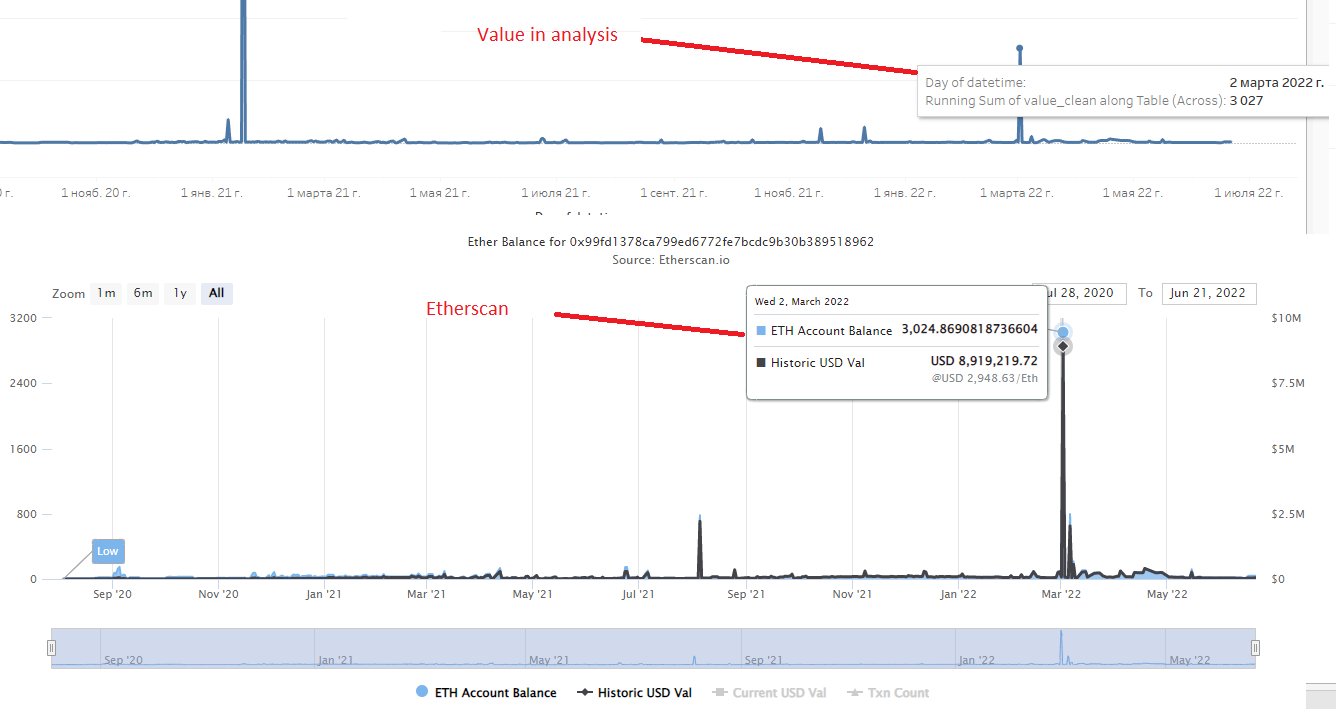

In [13]:
Image(filename='./pic/10_good_balance.png')

Generally, the shape of Balance graph is correct in running total calculation, the difference is observed in date:  

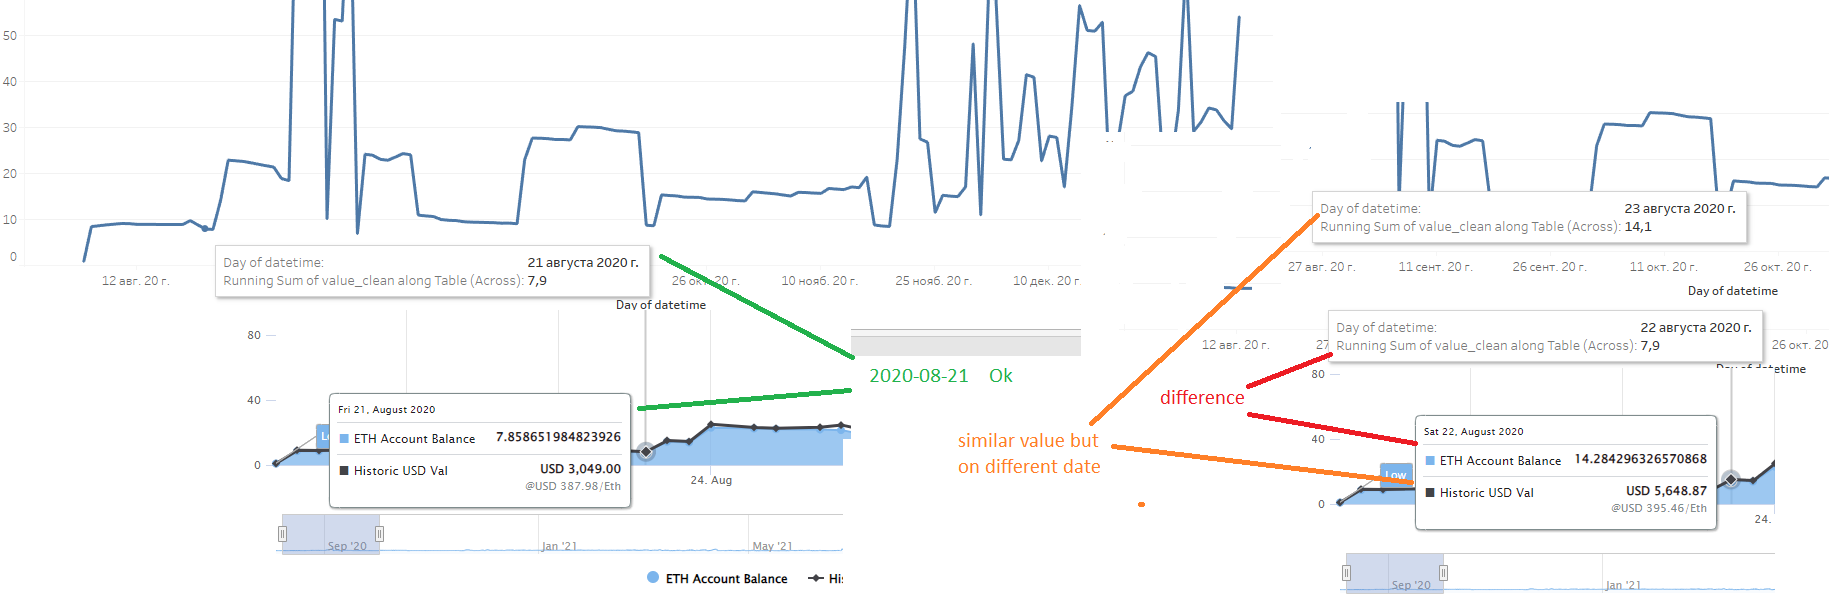

In [14]:
Image(filename='./pic/11_Difference_in_balance.png')

we see same balance on 21 August,   
but then we see difference in 22 August, where Running Total is remains the same, while Etherscan already shows new value, this difference then is eliminated but on 23 August in Running Total analysis,so basically there is 1 day Lag in Running total Analysis  
for the purpose of the current Analysis, such difference is not crucial, but we should stay aware of that difference

Lets now look at the biggest transactions:

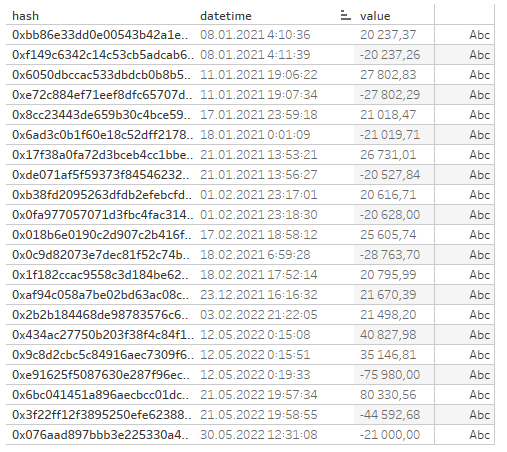

In [17]:
Image(filename='./pic/12_biggest_transactions.png')

these are transactions, that are bigger then 20 000 ETH per transaction

if we look closer on them we can see:  
- some of them are go by pairs (as the example of Compound transaction)
    - pairs have close timing
    - and similar values with different signs  

such transactions probably can be categorized as Loans (user gives Tokens to Dapp to earn interest on that tokens), let's check this theory and look deeply on some of such transactions

In [141]:
tx_dapp = pd.DataFrame({
    'tx_hash': ['0x0fa977057071d3fbc4fac314c2e0631db7a37139c2c8631c7f22a173e50b9381',
                '0x0c9d82073e7dec81f52c74b1949ea9a711b3965dc7ddb3aa35fc25beb0122b0d',
                '0xe91625f5087630e287f96ec9f7838c7e82b8eb820096dd2e84990d717609d5de',
                '0x3f22ff12f3895250efe623888b4919a1a9abdec617bf9a677ecf359e905bdbda',
                '0xb64d741fbaa9ef6220807e6f45a230c5b8354e5f383ea78bcec4b9d430aff60b',
                '0x7a0ed76a86fc5e80fde334c587b71bddbd5d7d5a2fb7d68476d2447983d29173',
                '0x8cf30ec693806b68b6822d093722e0424cbd573ce646d023ce9b126c02d1f41f',
                '0x907d4b1b6f930f56d2643f148dd95e76f3f2b338ba78b5c4b60b4776c9d1bb0d',
                '0x234ba280aa478ea855c880de915ae8dbe0ad716127ce5745a9c014420cc36e0f',
                '0x85625b73451f9e2b4bcad817b12e42719b289166ae223577a83238585d37deba',
                '0xe114204090da59413cdcfbc41516262006c888b967395be5defc8bd046d365dd',
                '0x30c125b3c2c5d3ff618e48440ad1455d95e1ccc0d244fb15faaf4c52173c2e4e',
                '0x29f9cdc47e994fae0a0a12308ecb72d15dac669eca832b56a6dcd8a2f7ef07c7',
                '0xdc1eb69cf263410ad4938055c8d043eec877167e00d4746600fe6f9e94cb21bc',
                '0xe7b0359971e5a431dbb14d3de43cffbd52fd2ae1a1d823a1ea9580a2db29d100',
                '0xe50d18d10f854a5af61d492c94cc51382e608f57e7bc3a20830ecf763c0f9cb3',
                '0xc108362caad81ceda9bdeefa33b5c37b2aa9cf39c97f3c56f55286a1eb38ab0f',
                '0xa5b96b04a84efbfd246ed402b12ed90940a48095be1abe94b1b74a2cc3738124',
                '0xbb86e33dd0e00543b42a1ea20caa96d7183a5f244b5612a53e77e8dc24e72f57',
                '0xf149c6342c14c53cb5adcab6a72c1674eada0dfe18858c9f76995acba1123fc0',
                '0x6050dbccac533dbdcb0b8b55d9e8b086a7acb565942dbf59a9dd1952ccb662b7',
                '0xe72c884ef71eef8dfc65707db15cc280805b29ef3fe9b6fc54c6077fcf9b9dc1',
                '0x8cc23443de659b30c4bce591401122aaca2023b5d3633153b42fc7eb46eaad9a',
                '0x6ad3c0b1f60e18c52dff21782c6161eb36ab7cc974ab05ceeb1583b401f8a91a',
                '0x17f38a0fa72d3bceb4cc1bbeebc951f463a8d0ce13cce725d08754da08f6d0e6',
                '0xde071af5f59373f84546232ef36326ce66391004a170cd6f129b47c497eee794',
                '0xb38fd2095263dfdb2efebcfdc7a35279a42952a44dc936964c5e359b6c0ba83b',
                '0x018b6e0190c2d907c2b416fcacb7da28089293936cf95a4d3c0fb0094d6e9799',
                '0x1f182ccac9558c3d184be620e04d2d9e79017f205c6502003885e9aef002e9f6',
                '0xaf94c058a7be02bd63ac08cd6f6d5c3f8cd60a7e11f4638a3a927028523edc39',
                '0x2b2b184468de98783576c69102505b42151cbdf16d86ac7caa644492d791c458',
                '0x434ac27750b203f38f4c84f10e8270d3fcc42c04b32683cff745132aaf8a15fb',
                '0x9c8d2cbc5c84916aec7309f680cc15c243943e654bdf81c34516f2f19b26299f',
                '0x6bc041451a896aecbcc01dc8ea81da842b7b0dcfde7e26dcf85975edfe1ae3bc',
                '0x076aad897bbb3e225330a4ef585bc464e2922d06ac2cc41ca0f6ea2074e26970',
                '0x88dd6aca9855b28c55612833738dd3f56cdbffd5d5338319b5d0fefd6d271cb9',
                '0x849ed333a01a4a8ae2d1949ff73bd03c39239442a176acab3346217691e3c5c4',
                '0xa46ceb2955f1cd6a2e2d56b24417e3c551478d594fc370941a8f73dd6ac8dd41',
                '0xca5ed7a3ce20d175179894e4703cb7dc19a9ff02aa2963f2e3baf15b03af39b0',
                '0x7667f1906d9a39bf4296e9550fb931e02d9effdbecdd6f0e39c993e55d001c18',
                '0x6bb9bbe787f54d8128991583c617edabf8a86c134da1bedb3599354be9e515b0',
                '0x90027ae5ef8c1cd2e1d500324c438f00daecef9e390df1450b5708dffe1bef15',
                '0xe02c99bfda4f3c4ab9a0d23649b538bb322ddeccc212c0cf1f0d1944f85074cd',
                '0xe6c08e9271261a71644cbbafc329b4a3ca54eb2e9374fcf836048eccd0804982',
                '0x3c5b31820e3242c48d1cab246dad68c47e4eb850aa56a550764061a234245d45',
                '0x33cc2deaf2d54246afe8b3b9121c4ceab3113ff0d277b9fdf6e537c1f53ca9bf',
                '0x8f958e11eba62029f5aca4367233bc72ea1ffc858f2954b085c002c77962fd79',
                '0xffbc0757e3014fac0efe60931ee5007a2cfc57fbc0854d7918ebf88240bf7ba0',
                '0xc024581828678628cdf668c657cf0c4a7709a36f8ee12e41dbc6ee0f36ed0e30',
                '0xedf56ca62616321f2a11862b42f14523c1b3c16dc16dd7da7eae6b9f4b78e92f',
                '0xd4a9f78c4a7c1235cd41dbc67807aae9bd88e8aa5bed1e3a87ae8f35f10d2cca',
                '0xb821f457902008c5e4ab7dc9c1eed9e15a9f94a3d25bc14d2105b74f6871cfed',
                '0x4c91c54c8d3b44e8be7d0d086b1a8abf1edde832bbd91065455b84fec8fabaf7',
                '0x6618e55ba8be7955c711b466e7e0608d1ef6088aac306208a6379ff1815440f5',
                '0x9e61f32e2f2a21cf5e05e1179e25f8cc4ff607e446d8659f891c01a067c8edb3',
                '0x335201e04e21ee081e178780348308fdb4c54e77e8bbe703dd9a9791d6a63269',
                '0x52b25346387d60c526de43ec5ce71574852cbe40bcb2cec8aed9b40ce7d52996',
                '0xbb3a8587b66a0460086dda6fdca6e49436a467d3bb971a3aa77316d97933bd93',
                '0xc1b734a8ddda4fa157b3ed939231bd790896a9ec7bcba5e2e0aacd3165cb7454',
                '0x1bd459bc1add34c79827319149627dbf600feaa3f4577a704c5270c1d8e03f59',
                '0xb9b1d15ee5db13fceb15129744d32dbc6b0705c1ad3e9d6e02ed2b910437cfd9',
                '0x054de419b04d5621d355249d73490b13732f493a67a176c12ffd99a521e63c22',
                '0x89035f62dfbd2b603102217cd6fae9174c487162161abcaf40c2e59e8ae012cd'],
    'Dapp': ['Compound',
             'Alpha Finance Lab',
             'Lido',
             'Lido',
             'Alpha Finance Lab',
             'Compound',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Lido',
             'Lido',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Zapper.Fi',
             'Compound',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Alpha Finance Lab',
             'Alpha Finance Lab',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Alpha Finance Lab',
             'Alpha Finance Lab',
             'Alpha Finance Lab',
             'Zapper.Fi',
             'Zapper.Fi',
             'Compound',
             'Compound',
             'Lido',
             'Lido',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Compound',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Alpha Finance Lab',
             'Compound',
             'Compound',
             'Compound',
             'Zapper.Fi',
             'Compound',
             'Lido',
             'Lido',
             'Compound',
             'Aave',
             'Aave',
             'Wrapped Ether',
             'Wrapped Ether',
             'Wrapped Ether',
             '0x: Exchange Proxy',
             'Flush token',
             'Compound',
             'FTX Exchange',
             'Compound']
})

tx_dapp.head(2)

,tx_hash,Dapp
0,0x0fa977057071d3fbc4fac314c2e0631db7a37139c2c8...,Compound
1,0x0c9d82073e7dec81f52c74b1949ea9a711b3965dc7dd...,Alpha Finance Lab


In [142]:
len(['0x0fa977057071d3fbc4fac314c2e0631db7a37139c2c8631c7f22a173e50b9381',
                '0x0c9d82073e7dec81f52c74b1949ea9a711b3965dc7ddb3aa35fc25beb0122b0d',
                '0xe91625f5087630e287f96ec9f7838c7e82b8eb820096dd2e84990d717609d5de',
                '0x3f22ff12f3895250efe623888b4919a1a9abdec617bf9a677ecf359e905bdbda',
                '0xb64d741fbaa9ef6220807e6f45a230c5b8354e5f383ea78bcec4b9d430aff60b',
                '0x7a0ed76a86fc5e80fde334c587b71bddbd5d7d5a2fb7d68476d2447983d29173',
                '0x8cf30ec693806b68b6822d093722e0424cbd573ce646d023ce9b126c02d1f41f',
                '0x907d4b1b6f930f56d2643f148dd95e76f3f2b338ba78b5c4b60b4776c9d1bb0d',
                '0x234ba280aa478ea855c880de915ae8dbe0ad716127ce5745a9c014420cc36e0f',
                '0x85625b73451f9e2b4bcad817b12e42719b289166ae223577a83238585d37deba',
                '0xe114204090da59413cdcfbc41516262006c888b967395be5defc8bd046d365dd',
                '0x30c125b3c2c5d3ff618e48440ad1455d95e1ccc0d244fb15faaf4c52173c2e4e',
                '0x29f9cdc47e994fae0a0a12308ecb72d15dac669eca832b56a6dcd8a2f7ef07c7',
                '0xdc1eb69cf263410ad4938055c8d043eec877167e00d4746600fe6f9e94cb21bc',
                '0xe7b0359971e5a431dbb14d3de43cffbd52fd2ae1a1d823a1ea9580a2db29d100',
                '0xe50d18d10f854a5af61d492c94cc51382e608f57e7bc3a20830ecf763c0f9cb3',
                '0xc108362caad81ceda9bdeefa33b5c37b2aa9cf39c97f3c56f55286a1eb38ab0f',
                '0xa5b96b04a84efbfd246ed402b12ed90940a48095be1abe94b1b74a2cc3738124',
                '0xbb86e33dd0e00543b42a1ea20caa96d7183a5f244b5612a53e77e8dc24e72f57',
                '0xf149c6342c14c53cb5adcab6a72c1674eada0dfe18858c9f76995acba1123fc0',
                '0x6050dbccac533dbdcb0b8b55d9e8b086a7acb565942dbf59a9dd1952ccb662b7',
                '0xe72c884ef71eef8dfc65707db15cc280805b29ef3fe9b6fc54c6077fcf9b9dc1',
                '0x8cc23443de659b30c4bce591401122aaca2023b5d3633153b42fc7eb46eaad9a',
                '0x6ad3c0b1f60e18c52dff21782c6161eb36ab7cc974ab05ceeb1583b401f8a91a',
                '0x17f38a0fa72d3bceb4cc1bbeebc951f463a8d0ce13cce725d08754da08f6d0e6',
                '0xde071af5f59373f84546232ef36326ce66391004a170cd6f129b47c497eee794',
                '0xb38fd2095263dfdb2efebcfdc7a35279a42952a44dc936964c5e359b6c0ba83b',
                '0x018b6e0190c2d907c2b416fcacb7da28089293936cf95a4d3c0fb0094d6e9799',
                '0x1f182ccac9558c3d184be620e04d2d9e79017f205c6502003885e9aef002e9f6',
                '0xaf94c058a7be02bd63ac08cd6f6d5c3f8cd60a7e11f4638a3a927028523edc39',
                '0x2b2b184468de98783576c69102505b42151cbdf16d86ac7caa644492d791c458',
                '0x434ac27750b203f38f4c84f10e8270d3fcc42c04b32683cff745132aaf8a15fb',
                '0x9c8d2cbc5c84916aec7309f680cc15c243943e654bdf81c34516f2f19b26299f',
                '0x6bc041451a896aecbcc01dc8ea81da842b7b0dcfde7e26dcf85975edfe1ae3bc',
                '0x076aad897bbb3e225330a4ef585bc464e2922d06ac2cc41ca0f6ea2074e26970',
                '0x88dd6aca9855b28c55612833738dd3f56cdbffd5d5338319b5d0fefd6d271cb9',
                '0x849ed333a01a4a8ae2d1949ff73bd03c39239442a176acab3346217691e3c5c4',
                '0xa46ceb2955f1cd6a2e2d56b24417e3c551478d594fc370941a8f73dd6ac8dd41',
                '0xca5ed7a3ce20d175179894e4703cb7dc19a9ff02aa2963f2e3baf15b03af39b0',
                '0x7667f1906d9a39bf4296e9550fb931e02d9effdbecdd6f0e39c993e55d001c18',
                '0x6bb9bbe787f54d8128991583c617edabf8a86c134da1bedb3599354be9e515b0',
                '0x90027ae5ef8c1cd2e1d500324c438f00daecef9e390df1450b5708dffe1bef15',
                '0xe02c99bfda4f3c4ab9a0d23649b538bb322ddeccc212c0cf1f0d1944f85074cd',
                '0xe6c08e9271261a71644cbbafc329b4a3ca54eb2e9374fcf836048eccd0804982',
                '0x3c5b31820e3242c48d1cab246dad68c47e4eb850aa56a550764061a234245d45',
                '0x33cc2deaf2d54246afe8b3b9121c4ceab3113ff0d277b9fdf6e537c1f53ca9bf',
                '0x8f958e11eba62029f5aca4367233bc72ea1ffc858f2954b085c002c77962fd79',
                '0xffbc0757e3014fac0efe60931ee5007a2cfc57fbc0854d7918ebf88240bf7ba0',
                '0xc024581828678628cdf668c657cf0c4a7709a36f8ee12e41dbc6ee0f36ed0e30',
                '0xedf56ca62616321f2a11862b42f14523c1b3c16dc16dd7da7eae6b9f4b78e92f',
                '0xd4a9f78c4a7c1235cd41dbc67807aae9bd88e8aa5bed1e3a87ae8f35f10d2cca',
                '0xb821f457902008c5e4ab7dc9c1eed9e15a9f94a3d25bc14d2105b74f6871cfed',
                '0x4c91c54c8d3b44e8be7d0d086b1a8abf1edde832bbd91065455b84fec8fabaf7',
                '0x6618e55ba8be7955c711b466e7e0608d1ef6088aac306208a6379ff1815440f5',
                '0x9e61f32e2f2a21cf5e05e1179e25f8cc4ff607e446d8659f891c01a067c8edb3',
                '0x335201e04e21ee081e178780348308fdb4c54e77e8bbe703dd9a9791d6a63269',
                '0x52b25346387d60c526de43ec5ce71574852cbe40bcb2cec8aed9b40ce7d52996',
                '0xbb3a8587b66a0460086dda6fdca6e49436a467d3bb971a3aa77316d97933bd93',
                '0xc1b734a8ddda4fa157b3ed939231bd790896a9ec7bcba5e2e0aacd3165cb7454',
                '0x1bd459bc1add34c79827319149627dbf600feaa3f4577a704c5270c1d8e03f59',
                '0xb9b1d15ee5db13fceb15129744d32dbc6b0705c1ad3e9d6e02ed2b910437cfd9',
                '0x054de419b04d5621d355249d73490b13732f493a67a176c12ffd99a521e63c22',
                '0x054de419b04d5621d355249d73490b13732f493a67a176c12ffd99a521e63c22'])

63

In [143]:
dapp_business = pd.DataFrame({
    'Dapp': ['Compound',
             'Alpha Finance Lab',
             'Lido',
             'Zapper.Fi',
             'Aave',
             'Wrapped Ether',
             '0x: Exchange Proxy',
             'FTX Exchange'],
    'Business': ['Lending',
                 'Lending',
                 'Staking',
                 'Staking',
                 'Lending',
                 'Change to ERC-20 Standard',
                 'Arbitrage',
                 'Centralized cryptocurrency exchange specializing in derivatives and leveraged products']
})

dapp_business

,Dapp,Business
0,Compound,Lending
1,Alpha Finance Lab,Lending
2,Lido,Staking
3,Zapper.Fi,Staking
4,Aave,Lending
5,Wrapped Ether,Change to ERC-20 Standard
6,0x: Exchange Proxy,Arbitrage
7,FTX Exchange,Centralized cryptocurrency exchange specializi...


In [144]:
# join dapp business to transactions:
tx_business = pd.merge(tx_dapp, dapp_business, how='left', on='Dapp')
tx_business.head()

,tx_hash,Dapp,Business
0,0x0fa977057071d3fbc4fac314c2e0631db7a37139c2c8...,Compound,Lending
1,0x0c9d82073e7dec81f52c74b1949ea9a711b3965dc7dd...,Alpha Finance Lab,Lending
2,0xe91625f5087630e287f96ec9f7838c7e82b8eb820096...,Lido,Staking
3,0x3f22ff12f3895250efe623888b4919a1a9abdec617bf...,Lido,Staking
4,0xb64d741fbaa9ef6220807e6f45a230c5b8354e5f383e...,Alpha Finance Lab,Lending


In [145]:
# merge to the main dataset:
df = pd.merge(df, tx_business, how='left', left_on='hash', right_on='tx_hash')

In [146]:
df.to_csv('./data/user_data_final.csv')

so by looking only on the biggest transactions, we can say that address providing liquidity for Staking and Lending (earning interest)  

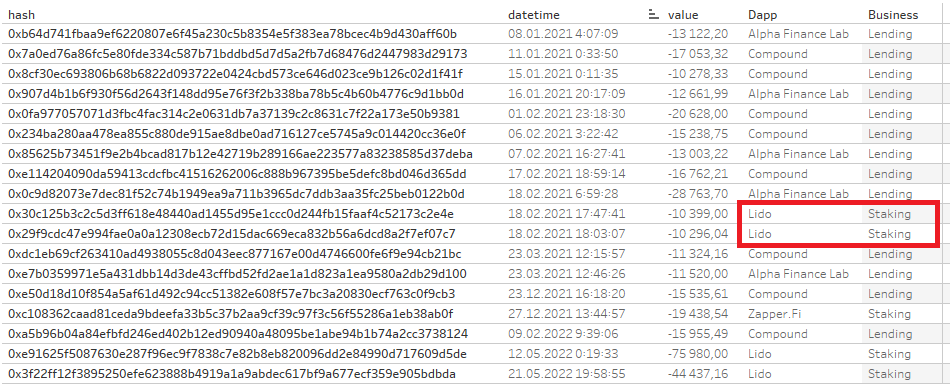

In [18]:
Image(filename='./pic/13_biggest_transactions_business.png')

In [147]:
# transaction:
tx_hash = '0x85a3c854972f313b6563832cb3dbeeef30523d76d09cbe51e1006d38b4888bb9'
tx_url = make_api_url(module="transaction", action="getstatus", txhash=tx_hash)
response = requests.get(tx_url)
data_tx = response.json()

In [148]:
data_tx

{'status': '1',
 'message': 'OK',
 'result': {'isError': '0', 'errDescription': ''}}

In [149]:
# transaction
tx_hash = '0x85a3c854972f313b6563832cb3dbeeef30523d76d09cbe51e1006d38b4888bb9'
tx_url = make_api_url(module="transaction", action="gettxreceiptstatus", txhash=tx_hash)
response = requests.get(tx_url)
data_tx = response.json()


In [150]:
data_tx

{'status': '1', 'message': 'OK', 'result': {'status': '1'}}

In [151]:
18958750998205045018 / 10**18

18.958750998205044

In [152]:

3081000000000000000000 / 10**18

3081.0

# ERC721 tokens (NFT)

let's not check whether there are transactions of NFT in Address

In [153]:
# nft:
url = make_api_url(module="account", action="tokennfttx", address=user_1, page=1, offset=10000, startblock=0, endblock=9999999999, sort='asc')
response = requests.get(url)
data_nft = response.json()
df_nft = df_from_response(data_nft)

In [154]:
df_nft.columns

Index(['blockNumber', 'timeStamp', 'hash', 'nonce', 'blockHash', 'from',
       'contractAddress', 'to', 'tokenID', 'tokenName', 'tokenSymbol',
       'tokenDecimal', 'transactionIndex', 'gas', 'gasPrice', 'gasUsed',
       'cumulativeGasUsed', 'input', 'confirmations'],
      dtype='object')

In [155]:
df_nft.loc[(df_nft['from'] == user_1) & (df_nft['to'] != user_1), 'is_sender'] = 1
df_nft.loc[(df_nft['from'] != user_1) & (df_nft['to'] == user_1), 'is_sender'] = 0
df_nft.loc[(df_nft['from'] == user_1) & (df_nft['to'] == user_1), 'is_sender'] = 999 # sender and receiver is the same

# convert timestamp to datetime:
df_nft['datetime'] = df_nft['timeStamp'].apply(lambda x: from_timestamp_to_date(x))
# year month and day:
df_nft['year'] = df_nft['datetime'].dt.year
df_nft['month'] = df_nft['datetime'].dt.month
df_nft['day'] = df_nft['datetime'].dt.day

In [156]:
df_nft.to_csv('./data/nft_dataset.csv')

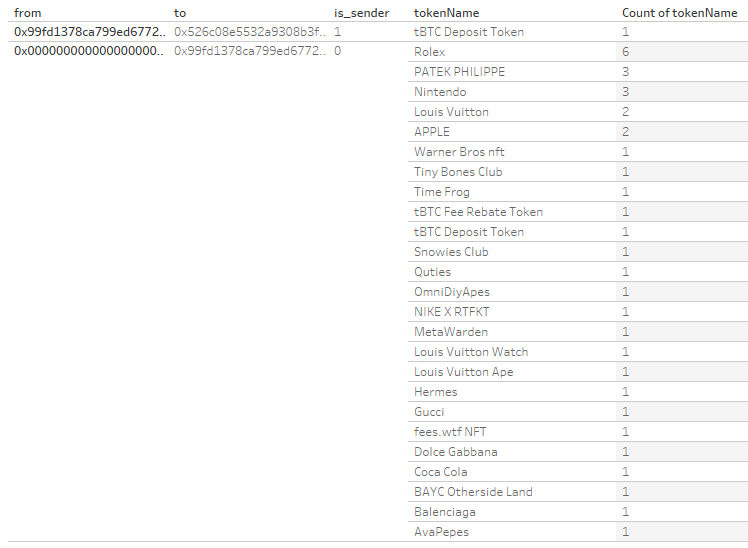

In [19]:
Image(filename='./pic/14_nft_COUNT.png')

- we can also see that the user buys NFT of famous brands like Rolex, Apple, Nike etc  
- user sold only 1 NFT (tBTC deposit token) in 2 hours after user bought it:  

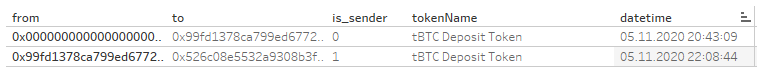

In [20]:
Image(filename='./pic/15_tBTC_but_sell.png')

In [157]:
df_nft[df_nft['tokenName'] == 'Rolex']['datetime']

16   2022-03-14 23:05:05
20   2022-03-21 23:54:44
22   2022-03-22 00:54:51
24   2022-03-22 22:43:55
26   2022-03-23 21:05:31
32   2022-03-24 20:53:25
Name: datetime, dtype: datetime64[ns]

Rolex NFT address bought within 1 month

So, we can describe strategy of User in NFT as creating a Collection

# ERC1155 tokens

In [158]:
# nft:
url = make_api_url(module="account", action="token1155tx", address=user_1, page=1, offset=10000, startblock=0, endblock=9999999999, sort='asc')
response = requests.get(url)
data_nft = response.json()
df_erc1155 = df_from_response(data_nft)
df_erc1155['datetime'] = df_erc1155['timeStamp'].apply(lambda x: from_timestamp_to_date(x))

In [159]:
df_erc1155

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,gas,gasPrice,gasUsed,cumulativeGasUsed,input,contractAddress,from,to,tokenID,tokenValue,tokenName,tokenSymbol,confirmations,datetime
0,11909231,1614028820,0xa432a3005fc1a9d6ac91cbf6f1e18397008bae28c995...,215,0x63d4a5bc48452583fee64fd11359b46b9ac282486548...,192,54497,210000000000,54497,11567580,deprecated,0xd07dc4262bcdbf85190c01c996b4c06a461d2430,0x7f67f31da8e1c2f64c62dce1d9d86039cf377ec5,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,122756,1,Rarible,RARI,3107311,2021-02-23 07:20:20


In Feb 2022 user also bought token of Rarible NFT marketplace, which is a Govrernance token that gives holders right to influence Rarible development

# Blocks Mined by Address:

In [160]:
# mined:
url = make_api_url(module="account", action="getminedblocks", address=user_1, blocktype='blocks',  page=1, offset=10000)
response = requests.get(url)
data_mined = response.json()

In [161]:
data_mined

{'status': '0', 'message': 'No transactions found', 'result': []}

Therefore address is not a Miner

In [162]:
# eth_getTransactionReceipt:
txhash=tx_hash
url = make_api_url(module="proxy", action="eth_getTransactionReceipt", txhash=txhash)
response = requests.get(url)
data = response.json()

In [163]:
data

{'jsonrpc': '2.0',
 'id': 1,
 'result': {'blockHash': '0xf1f579e6c1a5d334186d95593acc847bc327ca0cac076e8973f7bb8a7d1efa49',
  'blockNumber': '0xb21ddb',
  'contractAddress': None,
  'cumulativeGasUsed': '0x90601c',
  'effectiveGasPrice': '0xe6f7cec00',
  'from': '0x99fd1378ca799ed6772fe7bcdc9b30b389518962',
  'gasUsed': '0x2d251',
  'logs': [{'address': '0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5',
    'topics': ['0x875352fb3fadeb8c0be7cbbe8ff761b308fa7033470cd0287f02f3436fd76cb9'],
    'data': '0x000000000000000000000000000000000000000000000000003dcdfcf67a5be60000000000000000000000000000000000000000000000000e84cf52775390d1000000000000000000000000000000000000000000001b733fad62635c4e4226',
    'blockNumber': '0xb21ddb',
    'transactionHash': '0x85a3c854972f313b6563832cb3dbeeef30523d76d09cbe51e1006d38b4888bb9',
    'transactionIndex': '0xb4',
    'blockHash': '0xf1f579e6c1a5d334186d95593acc847bc327ca0cac076e8973f7bb8a7d1efa49',
    'logIndex': '0xcb',
    'removed': False},
   {'address

# Key Figures

Talking about Key Figures, we consider:  
- IBIT (income before tax)
- PAT (profit after tax)
- EVA (economic value added)
- ROE (ROI) (Return on Investments)

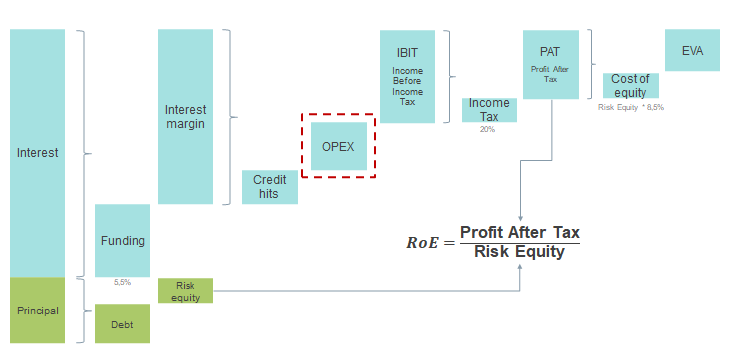

In [21]:
Image(filename='./pic/15_Key_figures_complex.png')

this figure shows how Key figures are calculated for traditional Loan.  
In case of Lending Schema in Ethereum network we will may apply the following assumptions:  
- Risk Equity is 100% own investments of user (or this funds can also be taken from some financial institution, therefore interest on them should be considered)
- User does not create Credit Hits as there are no regulations
- Opex of user will be considered = 100, since financial services perform all required actions after deligation (borrow)

In such conditions schema for calculating Key Figures will be significantly simplified:

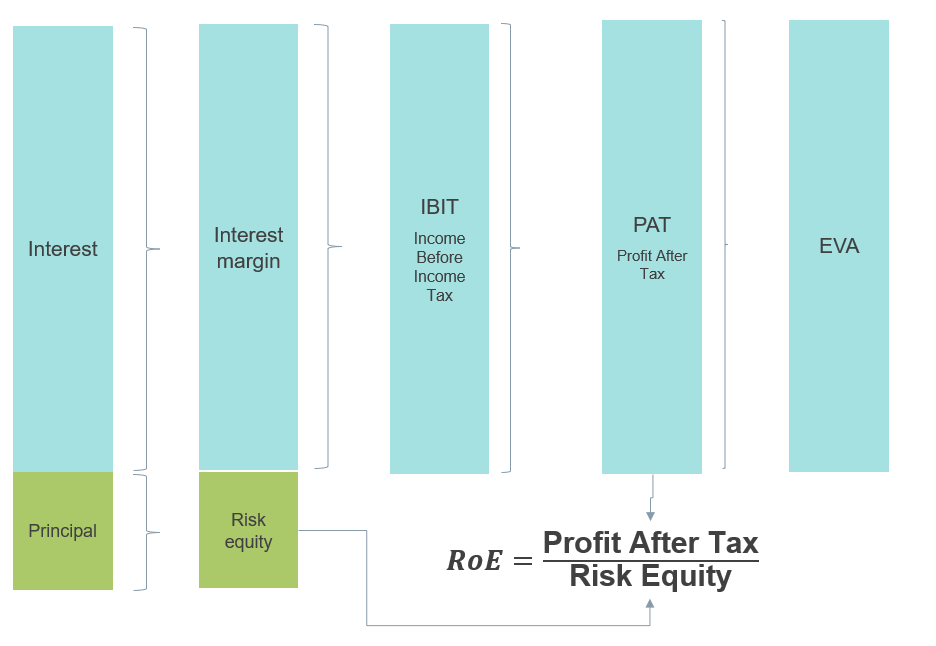

In [22]:
Image(filename='./pic/15_Key_figures_simplified.png')

- EVA = PAT = IBIT = Interest Margin
- Risk Equity = Initial Investments

### Join methods

In [164]:
df_methods = df_csv[['Txhash', 'Method']]

In [165]:
df.head(2)

,timeStamp,hash,from,to,value,tx_fee,is_internal,datetime,year,month,day,is_sender,value_clean,tx_hash,Dapp,Business
0,1596572493,0x4c3b415bb98370a9ef572567a4e13b61759763c08192...,0x04045a6c0a9f6ece044510c51b974400ade3ca5b,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,1.0,0.000000,0,2020-08-05 06:21:33,2020,8,5,0.0,1.000000,NaN,NaN,NaN
1,1596572800,0xdf08f1b6048a3c151737d797c5a5da5892cff66dfdfd...,0x99fd1378ca799ed6772fe7bcdc9b30b389518962,0x6317c5e82a06e1d8bf200d21f4510ac2c038ac81,-0.1,0.014775,0,2020-08-05 06:26:40,2020,8,5,1.0,-0.114775,NaN,NaN,NaN


In [166]:
df = pd.merge(df, df_methods, how='left', left_on='hash', right_on='Txhash')

In [167]:
df.to_csv('./data/user_data_final.csv')

Now looking at the transactions with Methods and Dapps (Financial Institutions), we can say that Address uses **speculative strategy**, often Borrowing assets to then invest them into another project, sometime for a very short term

this is best shown by the following graph:  

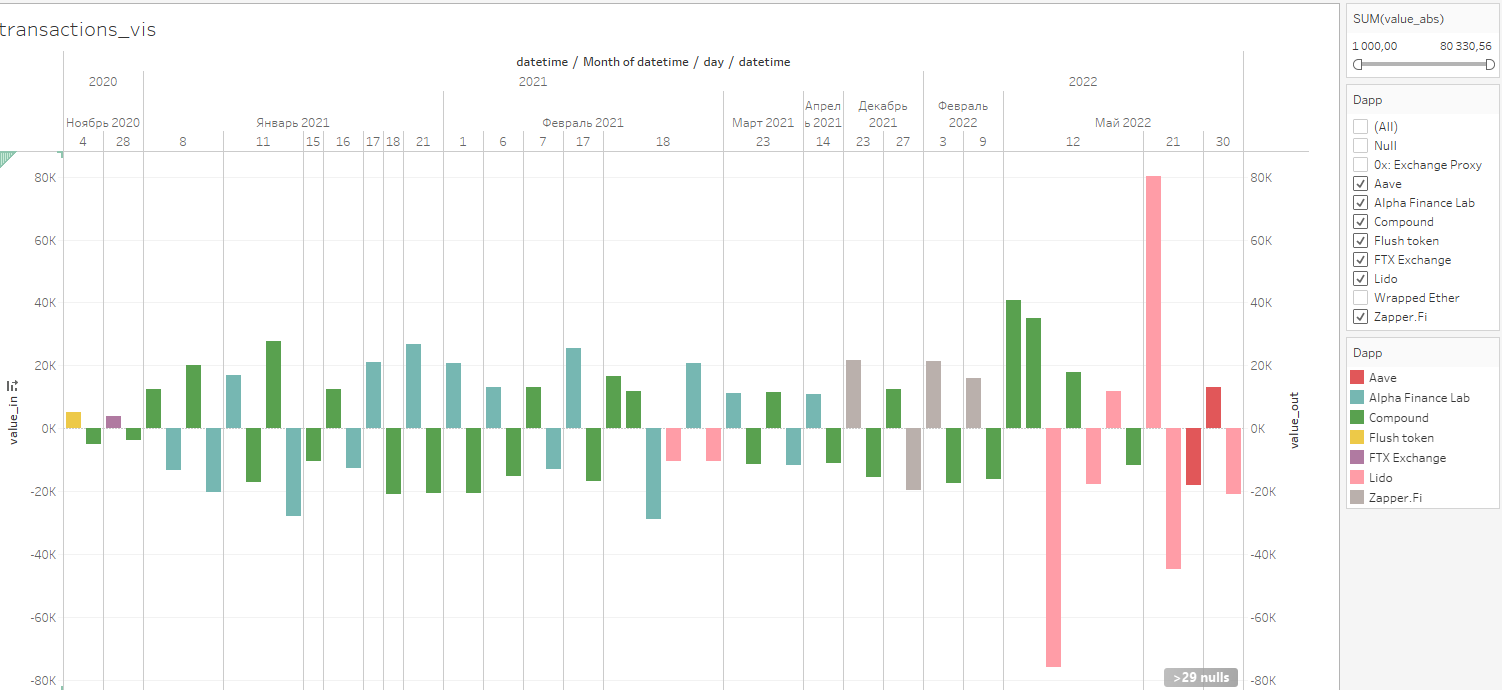

In [23]:
Image(filename='./pic/16_Transactions_Strategy.png')

Here we can see that within 1 day there are visible pattern of Pairs of Transactions:  
for example:  
- 8 Jan 2021 borrow 20 237 ETH from Compound
- a minute later Lend exact same 20 237 ETH into Alpha Finance Lab  
- repeat same pattern couple more times
- 18 Jan 2021 (10 days) Withdraw from Alpha finance Lab to then ...
- Pay Debt back to the Compound

In such way Address Put Liquidity from Compound to Alpha Finance, logically to get higher interest and create Margin to earn ETH

After, Lido Stacking, Zapper and Aave Lending also added to the Portfolio